In [1]:
import sys
sys.path.append('fashion-mnist')

from utils.mnist_reader import load_mnist

X_train, y_train = load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = load_mnist('fashion-mnist/data/fashion', kind='t10k')

In [2]:
import numpy as np
import seaborn as sns
from random import shuffle
from typing import Dict, List, Tuple, Iterable
from tqdm.notebook import tqdm

In [3]:
val_size = int(len(X_train)*0.1)

idx = np.arange(len(X_train))
shuffle(idx)
X_train, y_train = X_train[idx], y_train[idx]
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(54000, 784) (54000,)
(6000, 784) (6000,)
(10000, 784) (10000,)


<Axes: >

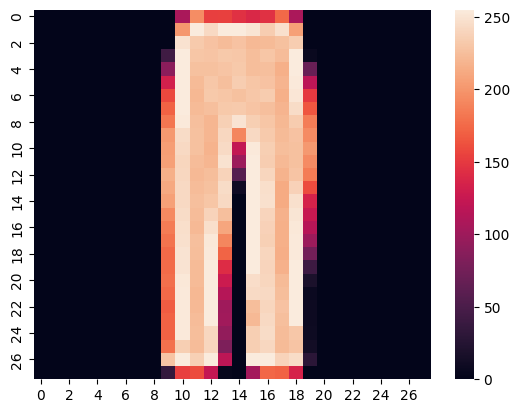

In [4]:
sns.heatmap(X_train[np.random.randint(len(X_train))].reshape(28, 28))

In [5]:
def data_loader(data: Tuple, batch_size: int, train: bool=False):
    if train:
        idx = np.arange(len(X_train))
        shuffle(idx)
        data = [x[idx] for x in data]
        
    for i in range(0, len(data[0]), batch_size):
        yield tuple(x[i:i+batch_size] for x in data)
        
def prepare_inputs(X: np.ndarray):
    return (X / 255) - 0.5

In [6]:
class Parameter:
    def __init__(self, data: np.ndarray):
        self.data = data
        self.grad = None
        
    def __repr__(self):
        return f"Parameter(data={self.data}, grad={self.grad})"

class Module:
    def __init__(self, **parameters: Dict[str, Parameter]):
        self.parameters: Dict[str, Parameter] = parameters
        self.training = False
    
    def __call__(self, *inputs):
        self._inputs = inputs
        self._outputs = self.forward(*inputs)
        return self._outputs
    
    def train(self, training: bool=True):
        self.training = training
        for k in dir(self):
            if isinstance(getattr(self, k), Module):
                getattr(self, k).train(training)
        
    def eval(self):
        self.train(False)
        
    def __repr__(self):
        modules = []
        for k in dir(self):
            if isinstance(getattr(self, k), Module):
                modules.append(f"{getattr(self, k)}")
                
        return f"{self.__class__.__name__}(\n" + "\n".join(["\t"+module for module in ",\n".join(modules).split("\n")]) + "\n)"
        
class ModuleList(Module):
    def __init__(self, modules: List[Module]=[]):
        self.modules = modules
        parameters = {}
        for i, module in enumerate(self.modules):
            parameters.update({f"{i}.{k}": v for k,v in module.parameters.items()})
            
        super().__init__(**parameters)
        
    def train(self, training: bool=True):
        super().train(training)
        for module in self.modules:
            module.train()
            
    def __len__(self) -> int:
        return len(self.modules)
            
    def __getitem__(self, idx: int) -> Module:
        return self.modules[idx]
            
    def __iter__(self) -> Iterable[Module]:
        for module in self.modules:
            yield module
            
    def __repr__(self):
        modules = ",\n".join([repr(module) for module in self.modules])
        return "ModuleList([\n" + "\n".join(["\t"+module for module in modules.split("\n")]) + "\n])"

In [7]:
class Linear(Module):
    def __init__(self, input_features: int, output_features: int):
        self.w = Parameter(np.random.randn(input_features, output_features) * np.sqrt(2 / input_features))
        self.b = Parameter(np.zeros(output_features))
        super().__init__(w=self.w, b=self.b)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        return X @ self.w.data + self.b.data
    
    def backward(self, grad_output: np.ndarray):
        X = self._inputs[0]
        self.w.grad = X.T @ grad_output
        self.b.grad = grad_output.sum(axis=0)
        return grad_output @ self.w.data.T
    
    def __repr__(self):
        return f"Linear({self.w.data.shape[0]},{self.w.data.shape[1]})"
    
class ReLU(Module):
    def forward(self, X: np.ndarray) -> np.ndarray:
        self._mask = X > 0
        return X * self._mask
    
    def backward(self, grad_output: np.ndarray):
        return grad_output * self._mask
    
    def __repr__(self):
        return f"ReLU()"
    
class Dropout(Module):
    def __init__(self, dropout: float):
        assert (0 <= dropout < 1)
        super().__init__()
        self.dropout = dropout
        
    def forward(self, X: np.ndarray) -> np.ndarray:        
        if self.training:
            self._mask = np.random.rand(*X.shape) > self.dropout
            return (X * self._mask) / (1 - self.dropout)
        
        return X
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        return (grad_output * self._mask) / (1 - self.dropout)
    
    def __repr__(self):
        return f"Dropout({self.dropout})"
    
class ResBlock(Module):
    def __init__(self, hidden_size: int, dropout: float):
        self.linear = Linear(hidden_size, hidden_size)
        self.relu = ReLU()
        self.dropout = Dropout(dropout)
        super().__init__(**self.linear.parameters)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        return self.dropout(self.relu(self.linear(X)) + X)
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        return self.linear.backward(self.relu.backward(self.dropout.backward(grad_output))) + grad_output
    
class Model(Module):
    def __init__(self, input_features: int, num_classes: int, hidden_sizes: List[int], dropout: float):
        self.layers = ModuleList([Linear(input_features, hidden_sizes[0]), ReLU()] + \
            [ResBlock(h, dropout) for h in hidden_sizes] + [Linear(hidden_sizes[-1], num_classes)])

        super().__init__(**self.layers.parameters)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            X = layer(X)
        return X
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output

In [8]:
def softmax(z: np.ndarray) -> np.ndarray:
    ez = np.exp(z - z.max(axis=-1, keepdims=True))
    return ez / ez.sum(axis=-1, keepdims=True)

def accuracy(preds: np.ndarray, targets: np.ndarray) -> float:
    return (preds == targets).mean().item()

In [9]:
class Loss(Module):
    def forward(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
        logits -= logits.max(axis=-1, keepdims=True)
        return (np.log(np.sum(np.exp(logits), axis=-1)) - logits[np.arange(len(y)), y]).mean()
    
    def backward(self, _) -> np.ndarray:
        logits, y = self._inputs
        grads = softmax(logits)
        grads[np.arange(len(y)), y] -= 1
        return grads / len(y)

In [10]:
class SGD:
    def __init__(self, params: List[Parameter], lr: float, weight_decay: float=0.0, max_grad_norm: float=1.0):
        self.params = params
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_grad_norm = max_grad_norm
        
    def step(self):
        for param in self.params:
            param.grad *= self.max_grad_norm / max(self.max_grad_norm, (param.grad ** 2).sum())
            param.data -= self.lr * (param.grad + self.weight_decay * param.data)
            
    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [11]:
input_features = 784
output_classes = 10
hidden_sizes = [32,32]
dropout = 0.0
batch_size = 128
lr = 0.03
weight_decay = 0.0
num_epochs = 10

model = Model(input_features, output_classes, hidden_sizes, dropout)
loss_fn = Loss()
optim = SGD(list(model.parameters.values()), lr=lr, weight_decay=weight_decay)

In [12]:
def train_epoch(pbar):
    pbar.total = len(X_train)
    train_loss = 0
    num_train_samples = 0
    model.train()
    for X, y in data_loader((X_train, y_train), batch_size, True):
        loss = loss_fn(model(prepare_inputs(X)), y)

        optim.zero_grad()
        model.backward(loss_fn.backward(None))
        optim.step()

        train_loss += (loss * len(X)).item()
        num_train_samples += len(X)
        pbar.update(len(X))
        pbar.set_postfix({"train_loss": train_loss / num_train_samples})
        
    return train_loss / num_train_samples
        

def evaluate(pbar, data):
    X_val, y_val = data
    pbar.total = len(X_val)
    val_loss = 0
    num_val_samples = 0
    preds = []
    model.eval()
    for X, y in data_loader((X_val, y_val), batch_size, False):
        outputs = model(prepare_inputs(X))
        loss = loss_fn(outputs, y)
        preds += outputs.argmax(axis=-1).tolist()

        val_loss += (loss * len(X)).item()
        num_val_samples += len(X)
        pbar.update(len(X))
        pbar.set_postfix({"val_loss": val_loss / num_val_samples, "accuracy": accuracy(np.asarray(preds), y_val[:num_val_samples])})
        
    return val_loss / num_val_samples, accuracy(np.asarray(preds), y_val[:num_val_samples])

In [13]:
with tqdm() as pbar:
    pbar.set_description("Val")
    val_loss, val_accuracy = evaluate(pbar, (X_val, y_val))
    print(f"Initial: {val_loss=}, {val_accuracy}")
    
    for epoch in range(num_epochs):
        pbar.set_description("Train")
        train_loss = train_epoch(pbar)

        pbar.set_description("Val")
        val_loss, val_accuracy = evaluate(pbar, (X_val, y_val))
        
        print(f"Epoch {epoch}: {train_loss=}, {val_loss=}, {val_accuracy=}")

    pbar.set_description("Test")
    test_loss, test_accuracy = evaluate(pbar, (X_test, y_test))
    
print(f"Test accuracy: {test_loss=}, {test_accuracy}")

0it [00:00, ?it/s]

Initial: val_loss=2.709822491186839, 0.065
Epoch 0: train_loss=0.8847885136377799, val_loss=0.569240497325924, val_accuracy=0.7948333333333333
Epoch 1: train_loss=0.5308202354139758, val_loss=0.5111125971757711, val_accuracy=0.8116666666666666
Epoch 2: train_loss=0.4794496373153332, val_loss=0.4708176415208363, val_accuracy=0.8306666666666667
Epoch 3: train_loss=0.4494190809869097, val_loss=0.45258485973726714, val_accuracy=0.8395
Epoch 4: train_loss=0.43003469073152956, val_loss=0.44030610785887475, val_accuracy=0.8445
Epoch 5: train_loss=0.4153832440797153, val_loss=0.4296452610062156, val_accuracy=0.8418333333333333
Epoch 6: train_loss=0.4026815694501258, val_loss=0.4283944682910294, val_accuracy=0.8475
Epoch 7: train_loss=0.39202833275784643, val_loss=0.42735025086667094, val_accuracy=0.8446666666666667
Epoch 8: train_loss=0.3835453555295681, val_loss=0.4037769673458515, val_accuracy=0.8618333333333333
Epoch 9: train_loss=0.37649875719857306, val_loss=0.3950936011373671, val_accura